In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/NLP_Capgemini_2021/NLP @ X_HEC - 2K21/Midterm/")

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import ast
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import wordnet
from textblob import TextBlob
from datetime import datetime
from string import punctuation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP Libraries
import gensim
from gensim.test.utils import get_tmpfile
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Define parameters for notebook import
%matplotlib inline
pd.set_option('display.max_columns', 500)

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

DATAPATH = "data/"

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Try to name your data / dataframe explicitly. 
df = pd.read_csv(DATAPATH+"bokan.csv", usecols=range(1,6))

In [ ]:
df.head()

,resto,review_rating,review_text,review_link,source
0,BOKAN 38 Bar & 39 Rooftop,2,This place has potential but it has one the mo...,https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor
1,BOKAN 38 Bar & 39 Rooftop,5,"Wow, where do I start, we had the most amazing...",https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor
2,BOKAN 38 Bar & 39 Rooftop,5,"Whenever you visit London, Canary Wharf, you j...",https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor
3,BOKAN 38 Bar & 39 Rooftop,5,"Terrific view, service & atmosphere. The resta...",https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor
4,BOKAN 38 Bar & 39 Rooftop,2,I am coming very often at Bokan with my friend...,https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor


In [ ]:
print(df.shape)
print(df.describe())

(1028, 5)
       review_rating
count    1028.000000
mean        4.321984
std         1.133891
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000


In [ ]:
df[df['source']=='Google'].describe()

,review_rating
count,483.000000
mean,4.492754
std,0.996597
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
df[df['source']=='Tripadvisor'].describe()

,review_rating
count,545.000000
mean,4.170642
std,1.224092
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
#Remove punctuation
def remove_punctuation(text):
    return ''.join([c for c in text if c not in punctuation])

In [ ]:
#Remove stop words
stop_words = nltk.corpus.stopwords.words('english')
stop_list = ['th', 'bokan', 'london', 'canary', 'wharf', 'novotel']

for word in stop_list:
  stop_words.append(word)

def remove_stop_words(text):
    tokens = word_tokenize(text)
    return ' '.join([i for i in tokens if not i in stop_words])

In [ ]:
#basic cleaning
def basic_cleaning(corpus):

  #To lowercase
  corpus = [[x.lower() for x in line] for line in corpus]

  #Remove numbers
  corpus = [[re.sub(r'\d+', '', x) for x in line] for line in corpus]

  #Remove punctuation
  corpus = [[remove_punctuation(x) for x in line] for line in corpus]

  #Remove ’s, ’t
  corpus = [[x.replace('’s', '').replace('’t', '') for x in line] for line in corpus]

  #Remove stop words
  corpus = [[i for i in line if not i in stop_words] for line in corpus]

  #Remove empty strings
  corpus = [[i for i in line if i != ''] for line in corpus]
  
  return corpus

In [ ]:
df['review_text_clean'] = basic_cleaning(df['review_text'].str.split())

In [ ]:
#Lemmatizing
lemmatizer = WordNetLemmatizer()

#function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

#Lemmatize with tags
def lemmatize_sentence(sentence):
    #find the POS tag for each word
    nltk_tagged = nltk.pos_tag(sentence)  
    
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag in [wordnet.NOUN, wordnet.ADJ]:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
   
    return lemmatized_sentence

In [ ]:
df['review_text_clean'] = df['review_text_clean'].apply(lambda x: lemmatize_sentence(x))

In [ ]:
df.head()

,resto,review_rating,review_text,review_link,source,review_text_clean
0,BOKAN 38 Bar & 39 Rooftop,2,This place has potential but it has one the mo...,https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor,"[place, potential, unwelcoming, unmanned, diml..."
1,BOKAN 38 Bar & 39 Rooftop,5,"Wow, where do I start, we had the most amazing...",https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor,"[wow, start, evening, florian, service, except..."
2,BOKAN 38 Bar & 39 Rooftop,5,"Whenever you visit London, Canary Wharf, you j...",https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor,"[visit, roofbar, beer, snack]"
3,BOKAN 38 Bar & 39 Rooftop,5,"Terrific view, service & atmosphere. The resta...",https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor,"[terrific, view, service, restaurant, floor, s..."
4,BOKAN 38 Bar & 39 Rooftop,2,I am coming very often at Bokan with my friend...,https://www.tripadvisor.co.uk/ShowUserReviews-...,Tripadvisor,"[great, experience, nice, cocktail, friendly, ..."


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

plate_mask = 255 - np.array(Image.open(DATAPATH+"plate.png"))

In [ ]:
def from_corpus_to_word_cloud(df):
  stword = stop_words
  text = " ".join(review_text for review_text in df)
  wordcloud = WordCloud(background_color="white", stopwords=stword, mask=plate_mask, width=800, height=400).generate(text)

  plt.figure(figsize=(20,15))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

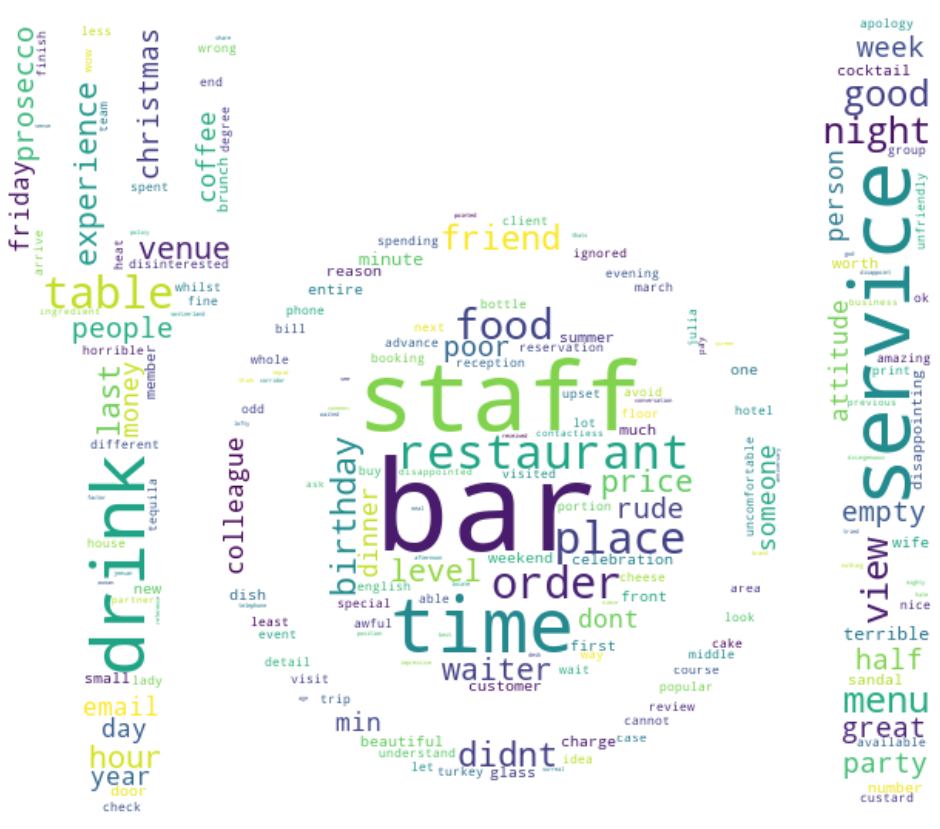

In [ ]:
corpus = [x for sub in df[df['review_rating']==1]['review_text_clean'] for x in sub]
from_corpus_to_word_cloud(corpus)

In [ ]:
def food(corpus):
  if 'food' in corpus:
    return 1
  else:
    return 0

def view(corpus):
  if 'view' in corpus:
    return 1
  else:
    return 0    

def service(corpus):
  if 'service' in corpus:
    return 1
  else:
    return 0  

def bad(corpus):
  if 'bad' in corpus:
    return 1
  else:
    return 0  

In [ ]:
df['food'] = df['review_text_clean'].apply(lambda x: food(x))
df['view'] = df['review_text_clean'].apply(lambda x: view(x))
df['service'] = df['review_text_clean'].apply(lambda x: service(x))
df['bad'] = df['review_text_clean'].apply(lambda x: bad(x))

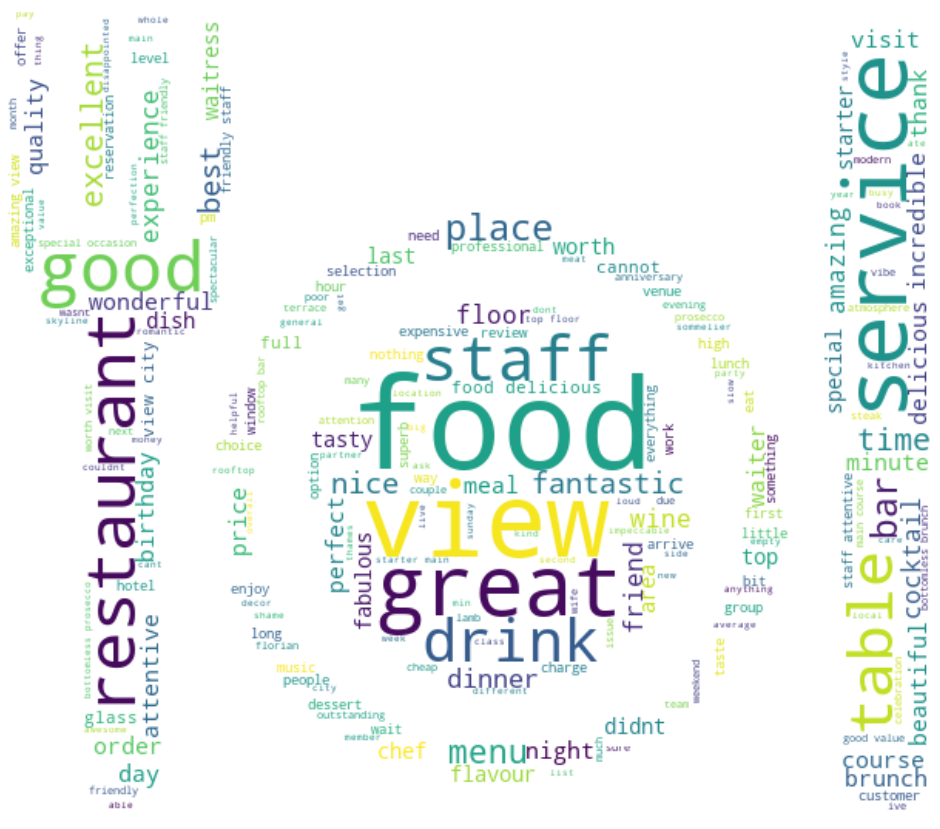

In [ ]:
corpus = [x for sub in df[df['food']==1]['review_text_clean'] for x in sub]
from_corpus_to_word_cloud(corpus)

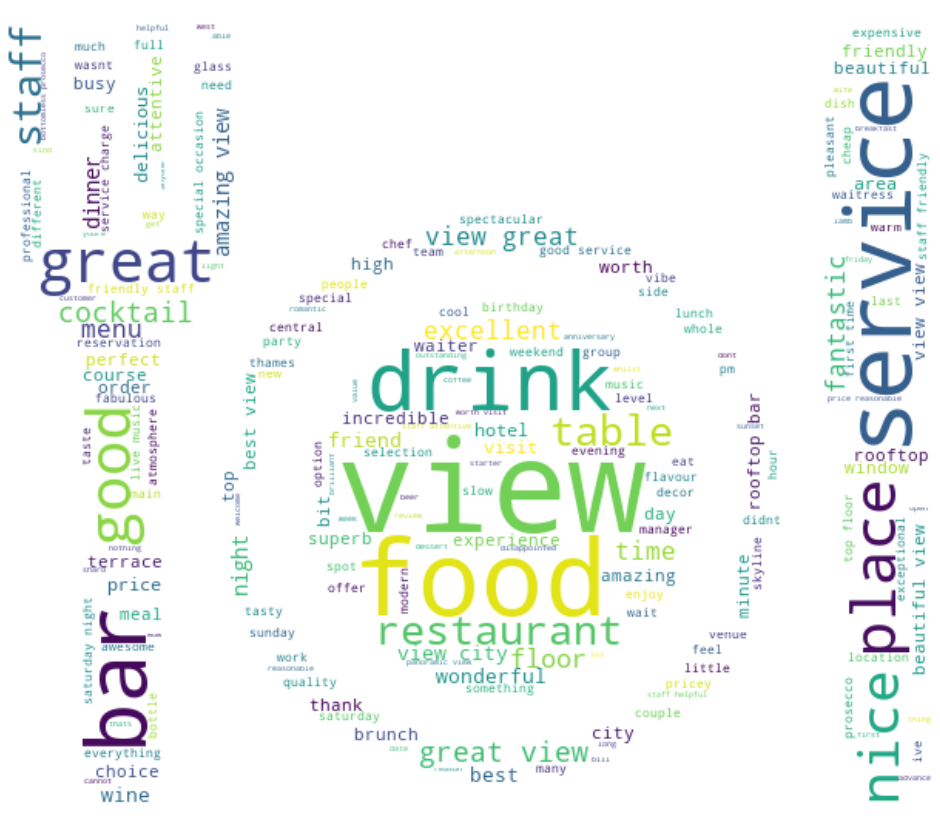

In [ ]:
corpus = [x for sub in df[df['view']==1]['review_text_clean'] for x in sub]
from_corpus_to_word_cloud(corpus)

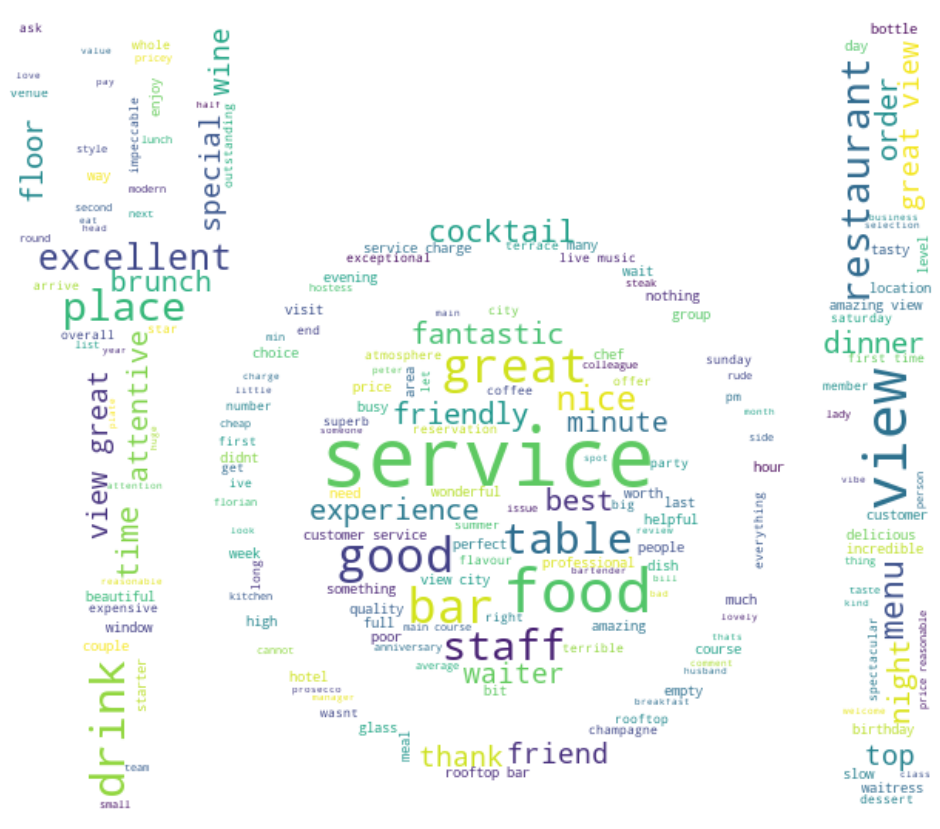

In [ ]:
corpus = [x for sub in df[df['service']==1]['review_text_clean'] for x in sub]
from_corpus_to_word_cloud(corpus)

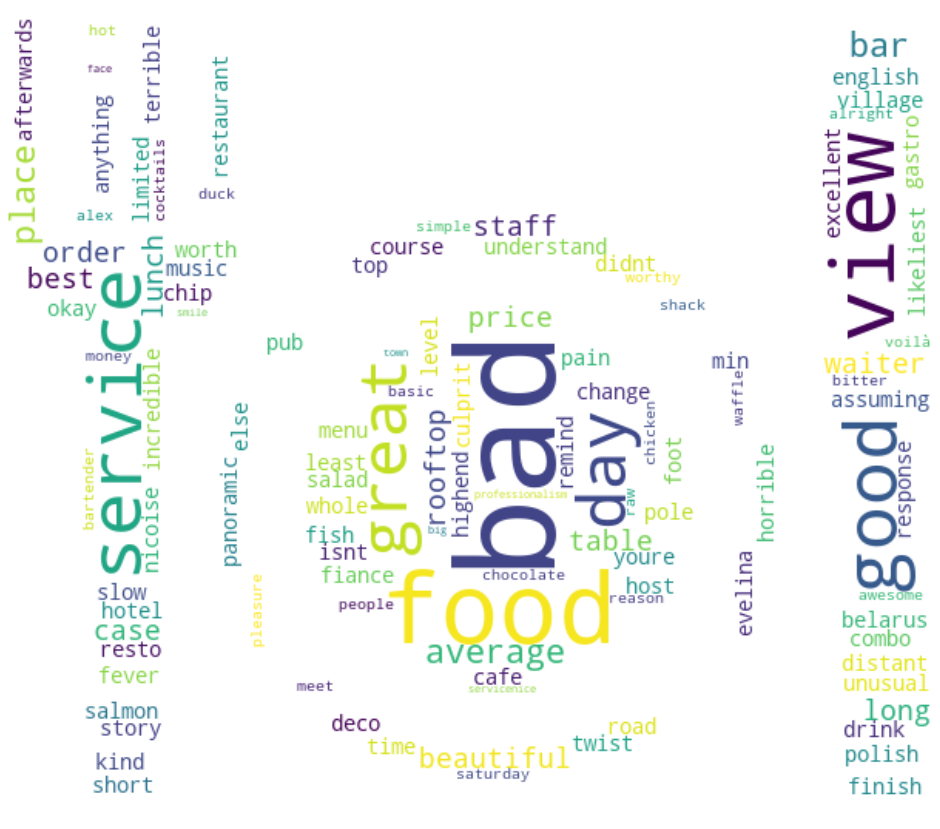

In [ ]:
corpus = [x for sub in df[df['bad']==1]['review_text_clean'] for x in sub]
from_corpus_to_word_cloud(corpus)

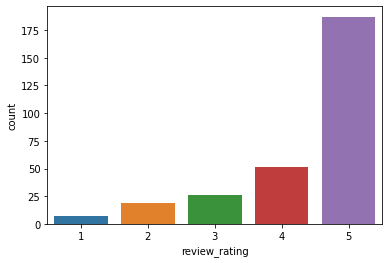

In [ ]:
sns.countplot(x=df[df['food']==1]['review_rating'])

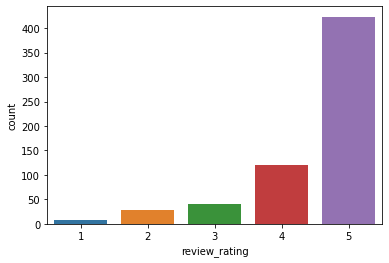

In [ ]:
sns.countplot(x=df[df['view']==1]['review_rating'])

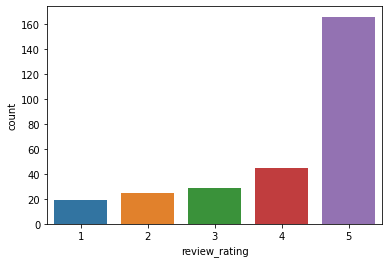

In [ ]:
sns.countplot(x=df[df['service']==1]['review_rating'])

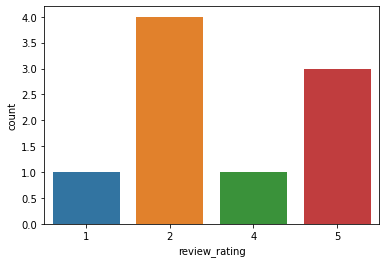

In [ ]:
sns.countplot(x=df[df['bad']==1]['review_rating'])

In [ ]:
resto = pd.read_csv(DATAPATH+"resto_review.csv", usecols=range(1,6))
resto['review_text_clean'] = basic_cleaning(resto['review_text'].str.split())
resto['review_text_clean'] = resto['review_text_clean'].apply(lambda x: lemmatize_sentence(x))

In [ ]:
path = get_tmpfile("w2v_all.model")
corpus = resto.review_text_clean
model_all = gensim.models.Word2Vec(size=300, window=3, min_count=5, workers=4, seed=1, iter=50)
model_all.build_vocab(corpus)
model_all.train(corpus, total_examples=model_all.corpus_count, epochs=model_all.iter)
model_all.save("w2v_all.model")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


In [ ]:
df1 = df[df['review_rating']<=2]

In [ ]:
path = get_tmpfile("word2vec.model")
corpus = df.review_text_clean
model = gensim.models.Word2Vec(size=300, window=3, min_count=5, workers=4, seed=1, iter=50)
model.build_vocab(corpus)
model.train(corpus, total_examples=model.corpus_count, epochs=model.iter)
model.save("word2vec.model")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


In [ ]:
common_words = []
for tup in model.wv.most_similar("charge", topn=100):
  common_words.append(tup[0])

In [ ]:
[x[0] for x in nltk.pos_tag(common_words) if x[1]=='JJ'][:20]

['empty',
 'arrive',
 'long',
 '£',
 'poor',
 'sure',
 'table',
 'didnt',
 'wrong',
 'hostess',
 'understand',
 'full',
 'terrible',
 'lunch',
 'sunday',
 'first',
 'free',
 'overall',
 'crazy',
 'special']

In [ ]:
review_bad = [y for x in df['review_text_clean'] for y in x if y in common_words]

In [ ]:
from collections import Counter

wordcounts = Counter(review_bad)
wordcounts

Counter({'advance': 12,
         'anyone': 9,
         'anything': 9,
         'apology': 5,
         'arrive': 11,
         'ask': 11,
         'attention': 10,
         'attitude': 9,
         'bartender': 13,
         'beer': 12,
         'bill': 9,
         'booking': 5,
         'bottle': 18,
         'cannot': 14,
         'cant': 9,
         'celebrate': 9,
         'celebration': 10,
         'champagne': 7,
         'check': 6,
         'chip': 7,
         'coco': 5,
         'coffee': 16,
         'cold': 7,
         'crazy': 5,
         'customer': 25,
         'didnt': 36,
         'empty': 15,
         'enough': 5,
         'event': 6,
         'fine': 8,
         'first': 27,
         'free': 7,
         'front': 9,
         'full': 21,
         'get': 15,
         'glass': 27,
         'group': 18,
         'half': 9,
         'hostess': 10,
         'hour': 22,
         'im': 6,
         'jazz': 6,
         'job': 5,
         'kitchen': 9,
         'last': 35,
         

In [ ]:
def ambience(corpus):
  words = ['ambience', 'decor', 'light', 'vibe', 'atmosphere', 'music', 'loud']
  for w in words:
    if w in corpus:
      return 1

  return 0 

def menu(corpus):
  words = ['portion', 'dish', 'small', 'size', 'serving','menu','course']
  for w in words:
    if w in corpus:
      return 1

  return 0 

def veg(corpus):
  words = ['vegan','vegetarian','veg','veggie']
  for w in words:
    if w in corpus:
      return 1

  return 0 

df1['ambience'] = df1['review_text_clean'].apply(lambda x: ambience(x))
df1['menu'] = df1['review_text_clean'].apply(lambda x: menu(x))
df['veg'] = df['review_text_clean'].apply(lambda x: veg(x))
list(df1[df1['ambience']==1]['review_text'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['I ve been for the first time there, nice view but if you want some food at the bar, the best is to order the food first and the the drinks later, cuz it may take a while (in my case took more than 20 mins for some fries), the music is soo loud, it s like u re in a club, you can’t even have a discussion with the friends.',
 'Nice view, good food, but extremely loud due to dinner party in the restaurant. At times, it was impossible to understand the people sitting in front of you. Very unfortunate, were looking forward to a nice dinner.',
 'I was taken there for my birthday. The restaurant was full until 9pm, and so we had to settle for the bar. The place was very dark, and finding the table was not the say (for me, anyway). The awful din emitted by a woman squealing into a microphone (they tell me that it is singing; but it has nothing in common with Covent Garden) was so loud because, apparently, it has to carry over three floors in the building. The occasional breaks which she and h

In [ ]:
embedding_matrix = dict()

for word in model.wv.vocab.keys():
    embedding_matrix[word] = list(model.wv[word]) # get numpy vector of a word (wv = word vector)

embedding_matrix = pd.DataFrame(embedding_matrix)